In [19]:
%%capture --no-stderr
%pip install -U langgraph langchain_community

In [20]:
!pip install -U langchain
!pip install -qU langchain-groq

In [ ]:
import os
from dotenv import load_dotenv
load_dotenv()

# os.environ["OPENAI_API_KEY"]
# os.environ["LANGCHAIN_API_KEY"]
# os.environ["GROQ_API_KEY"]

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGCHAIN_PROJECT"] = "llama-agent"

In [45]:
import json
import pandas as pd
import psycopg2
from typing import Annotated, Literal
import tempfile

from langchain_core.messages import AIMessage, ToolMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_groq import ChatGroq
from langchain_openai import ChatOpenAI
from pydantic import BaseModel, Field
from typing_extensions import TypedDict

from langgraph.graph import END, START, StateGraph
from langgraph.graph.message import AnyMessage, add_messages

# Define the state for the agent
class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]
    csv_path: str
    output_csv_path: str
    user_prompt: str

# Define a new graph
workflow = StateGraph(State)

# Add a node for loading the CSV file
def load_csv(state: State) -> dict:
    csv_path = state["csv_path"]
    
    try:
        df = pd.read_csv(csv_path, delimiter=",") 
    except Exception as e:
        return {"messages": [AIMessage(content=f"Error loading CSV: {str(e)}")]}
    
    # Store the DataFrame in the state, but not in `messages`
    return {
        "messages": [AIMessage(content=f"Loaded CSV with {df.shape[0]} rows and {df.shape[1]} columns.")],
        "df": df  # ✅ Store the DataFrame correctly in state
    }

workflow.add_node("load_csv", load_csv)

# Add a node for generating the Python script
def generate_python_script(state: State) -> dict[str, list[AIMessage]]:
    user_prompt = state["user_prompt"]

    # Strict system prompt to enforce pure Python code output
    python_script_prompt = f"""
    You are an AI assistant that generates Python scripts for data processing.
    
    - Your output must be a valid and executable Python script.
    - Do NOT include explanations, markdown formatting, or code block markers (e.g., ```Python ... ```).
    - Fix errors that occur.
    - The script must read a CSV file, process it according to the user's request, and write the output to a new CSV file.

    # Variables:
    input_csv_path = "{state['csv_path']}"  # Input CSV file path
    output_csv_path = "{state['output_csv_path']}"  # Output CSV file path
    
    Example task: "Apply logarithmic scaling to total_stakes and total_rewards."
    """

    chat_model = ChatGroq(model_name="llama3-70b-8192", temperature=0.0)
    response = chat_model.invoke(f"{python_script_prompt} User request: {user_prompt}")

    script_code = response.content 

    script_code = script_code.replace("```Python", "").replace("```", "").strip()

    if not script_code:
        return {"messages": [AIMessage(content="Error: Python script generation failed.")]}

    print("Generated script:\n", script_code)  # Debugging step

    return {
        "messages": [AIMessage(content=script_code)],
        #"python_script": script_code, 
    }

workflow.add_node("generate_python_script", generate_python_script)

# Add a node for executing the Python script
# should be similar to query_gen_node
def execute_python_script(state: State) -> dict[str, list[AIMessage]]:
#    if "python_script" not in state:
#        return {"messages": [AIMessage(content="Error: No Python script found in state.")]} 
    
    script_code = state["messages"][-1].content
    input_csv_path = state["csv_path"]
    output_csv_path = state["output_csv_path"]
    output_txt_path = output_csv_path.replace(".csv", ".txt")

    if not os.path.exists(input_csv_path):
        return {"messages": [AIMessage(content=f"Error: Input CSV file not found at {input_csv_path}.")]}

    try:
        with tempfile.NamedTemporaryFile(suffix=".py", delete=False) as temp_script:
            temp_script.write(script_code.encode("utf-8"))
            temp_script_path = temp_script.name
        
        # Execute the script
        exec_globals = {"__file__": temp_script_path, "input_csv_path": input_csv_path, "output_csv_path": output_csv_path}
        exec(open(temp_script_path).read(), exec_globals)

        if not os.path.exists(output_csv_path):
            return {"messages": [AIMessage(content="Error: Output CSV file was not created.")]}
        
        # Load the newly generated CSV
        df = pd.read_csv(output_csv_path)
        
        # Generate column descriptions
        column_descriptions = []
        for col in df.columns:
            dtype = df[col].dtype
            sample_values = df[col].dropna().sample(min(3, len(df)), random_state=42).tolist() if not df[col].isna().all() else []
            column_descriptions.append(f"{col}")
            #({dtype}): Sample values -> [sample_values]")

        # Write descriptions to a TXT file
        with open(output_txt_path, "w") as txt_file:
            txt_file.write("\n".join(column_descriptions))

        return {
            "messages": [AIMessage(content=f"Python script executed successfully. Processed data saved to {output_csv_path}. Column descriptions saved to {output_txt_path}.")], 
            "output_csv_path": output_csv_path,
            "output_txt_path": output_txt_path
        }
    
    except Exception as e:
        return {"messages": [AIMessage(content=f"Error executing script: {str(e)}")]}  

workflow.add_node("execute_python_script", execute_python_script)

# Define workflow edges
workflow.add_edge(START, "load_csv")
workflow.add_edge("load_csv", "generate_python_script")
workflow.add_edge("generate_python_script", "execute_python_script")
workflow.add_edge("execute_python_script", END)

# Compile workflow
app = workflow.compile()

### Visualize the graph

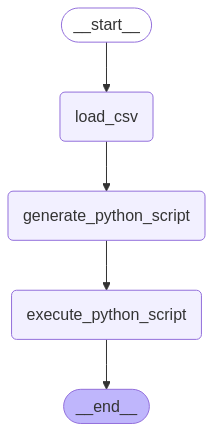

In [48]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

### Run the agent

In [ ]:
# Define input and output CSV file paths
input_csv_path = "./query_result.csv"  
output_csv_path = "./second_graph_output_orange.csv" 
user_prompt = '''
Generate a Python script to process raw pool stakes and rewards data from a CSV file, bin the data logarithmically, and compute median values per bin for plotting. Follow these steps:

1. Load the CSV file from 'input_csv_path' into a pandas DataFrame. The CSV contains columns 'total_stakes' and 'total_rewards'.
2. Filter out rows where 'total_stakes' or 'total_rewards' are zero or negative.
3. Compute base-10 logarithms of 'total_stakes' and 'total_rewards', storing them as 'log_stakes' and 'log_rewards'.
4. Create 30 logarithmically spaced bins using np.linspace, spanning the minimum to maximum of 'log_stakes' in the log scale.
5. Assign 'log_stakes' to these bins using pd.cut with labels=False and include_lowest=True, creating a column 'bin_center'.
6. Group the DataFrame by 'bin_center' using groupby('bin_center', observed=True) and compute medians for all numeric columns using median(numeric_only=True).
7. Compute 'median_stakes' as 10**median('log_stakes') and 'median_rewards' as 10**median('log_rewards'), storing them as columns in the DataFrame.
8. Create a DataFrame with these 6 columns 'total_stakes' (must have), 'total_rewards'(must have), 'log_stakes', 'log_rewards', 'median_stakes', 'median_rewards', and save it to 'output_csv_path' without the index.

The script should use pandas and numpy.
'''
#"Process the raw data to calculate the median pool rewards per bin based on logarithmic binning of pool stakes. Use log-spaced bins to cover the full range of stake values. For each bin, compute the median reward of the corresponding stake values. Output the bin centers and the corresponding median rewards as a structured dataset for plotting."

# Initialize the workflow state
state = {
    "messages": [],
    "csv_path": input_csv_path,
    "output_csv_path": output_csv_path,
    "user_prompt": user_prompt
}

result = app.invoke(state)
print(result["messages"][-1].content) 

Generated script:
 import pandas as pd
import numpy as np

# Load the CSV file into a pandas DataFrame
df = pd.read_csv(input_csv_path)

# Filter out rows where 'total_stakes' or 'total_rewards' are zero or negative
df = df[(df['total_stakes'] > 0) & (df['total_rewards'] > 0)]

# Compute base-10 logarithms of 'total_stakes' and 'total_rewards'
df['log_stakes'] = np.log10(df['total_stakes'])
df['log_rewards'] = np.log10(df['total_rewards'])

# Create 30 logarithmically spaced bins
bins = np.linspace(df['log_stakes'].min(), df['log_stakes'].max(), 30)

# Assign 'log_stakes' to these bins
df['bin_center'] = pd.cut(df['log_stakes'], bins=bins, labels=False, include_lowest=True)

# Group the DataFrame by 'bin_center' and compute medians for all numeric columns
grouped_df = df.groupby('bin_center', observed=True).median(numeric_only=True).reset_index()

# Compute 'median_stakes' and 'median_rewards'
grouped_df['median_stakes'] = 10 ** grouped_df['log_stakes']
grouped_df['median_rewards'] = 1